In [6]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
import LEN_Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor



In [7]:
th = TH()

mimicDF = th.get_mimic()

mimicDF

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
mimicDF.describe()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,0.039755,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,0.195386,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,0.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,0.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,0.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,0.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,1.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [9]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [10]:
# for id in mimicDF['PatientID'].unique()[:1]:
#     patientDF = mimicDF[mimicDF['PatientID'] == id]
#     display(patientDF)

In [13]:


patients = th.get_patients()

print(len(patients))

1126


In [14]:
print(patients[0].patientID, '\n', patients[0].data)

178177 
     Mortality14Days  ALT  AST  Admit Ht  Albumin  Arterial BP Mean  \
0                 0  NaN  NaN       NaN      NaN               NaN   
1                 0  NaN  NaN       NaN      NaN               NaN   
2                 0  NaN  NaN       NaN      NaN               NaN   
3                 0  NaN  NaN       NaN      NaN               NaN   
4                 0  NaN  NaN       NaN      NaN               NaN   
5                 0  NaN  NaN       NaN      NaN               NaN   
6                 0  NaN  NaN       NaN      NaN               NaN   
7                 0  NaN  NaN       NaN      NaN               NaN   
8                 0  NaN  NaN       NaN      NaN               NaN   
9                 0  NaN  NaN       NaN      NaN               NaN   
10                0  NaN  NaN       NaN      NaN               NaN   
11                0  NaN  NaN       NaN      NaN               NaN   
12                0  NaN  NaN       NaN      NaN               NaN   
13         

In [15]:
nullCount = {}



for patient in patients:

    for column in patient.data.columns:

        if patient.data[column].isnull().all():

            if column not in nullCount:
                nullCount[column] = int(patient.data[column].isnull().all())
            else:
                nullCount[column] += int(patient.data[column].isnull().all())

nullCount = dict(sorted(nullCount.items(), key=lambda item: item[1]))


display(nullCount)


{'Platelets': 25,
 'Arterial BP [Diastolic]': 29,
 'Arterial BP [Systolic]': 29,
 'Arterial BP Mean': 30,
 'CVP': 36,
 'Arterial pH': 43,
 'Hemoglobin': 45,
 'Arterial PaCO2': 51,
 'Arterial PaO2': 51,
 'SVR': 57,
 'Ionized Calcium': 73,
 'SVRI': 77,
 'SVI': 123,
 'Resp Rate (Spont)': 219,
 'SaO2': 232,
 'CaO2': 313,
 'Potassium': 381,
 'Glucose': 382,
 'Sodium': 384,
 'BUN': 388,
 'Creatinine': 388,
 'Chloride': 389,
 'WBC': 395,
 'Daily Weight': 408,
 'INR': 442,
 'PTT': 444,
 'Magnesium': 445,
 'Admit Ht': 463,
 'NBP [Systolic]': 501,
 'NBP [Diastolic]': 516,
 'NBP Mean': 519,
 'Fibrinogen': 795,
 'ALT': 873,
 'AST': 876,
 'Total Bili': 955,
 'Albumin': 983,
 'LDH': 991,
 'SvO2': 1077,
 'Respiratory Rate (spontaneous)': 1125}

In [16]:

patientsKept = []
numPatientsKept = []

print(list(nullCount.keys())[:1])


for i in range(len(list(patient.data.columns)[:15])):

    # print(i)

    columnsToKeep = list(nullCount.keys())[:i+1]

    print(f"Keeping {columnsToKeep}")

    nonNullPatients = []

    for patient in patients:

        for col in columnsToKeep:

            if patient.data[col].isnull().all():
                break
        
        else:
            patient.clusteringColumns = patient.data[columnsToKeep]
            # print(patient.clusteringColumns)
            nonNullPatients.append(copy.copy(patient))
        
    
    print(nonNullPatients[0].clusteringColumns.columns)


    # nonNullPatients = [patient for patient in patients if not patient.data[columnsToKeep].isnull().all().all()]


    print(len(nonNullPatients))

    patientsKept.append(nonNullPatients)
    numPatientsKept.append(len(nonNullPatients))

print(len(patientsKept))

# display(patients[0].data[columnsToKeep])

['Platelets']
Keeping ['Platelets']
Index(['Platelets'], dtype='object')
1101
Keeping ['Platelets', 'Arterial BP [Diastolic]']
Index(['Platelets', 'Arterial BP [Diastolic]'], dtype='object')
1076
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]'], dtype='object')
1076
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean'],
      dtype='object')
1075
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP'],
      dtype='object')
1057
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP', 'Arterial pH']
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial 

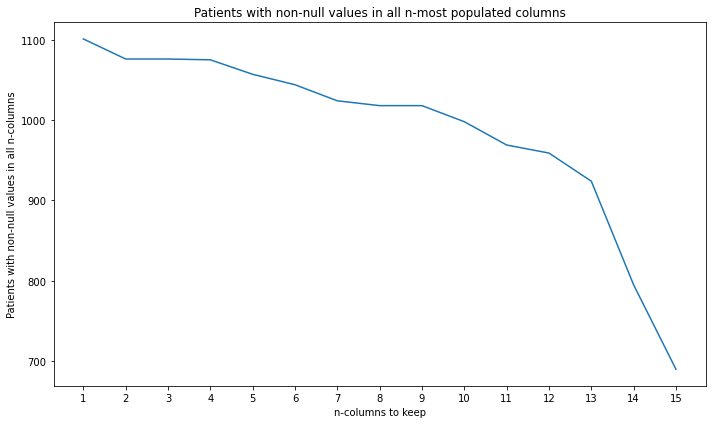

In [17]:
patientsKeptDF = pd.DataFrame(data=numPatientsKept)

patientsKeptDF['n_col'] =list(range(1, len(patientsKeptDF)+1))

patientsKeptDF = patientsKeptDF.set_index('n_col')



fig = plt.figure(figsize=(10, 6))

plt.xticks(patientsKeptDF.iloc[:,0].index)
plt.xlabel("n-columns to keep")
plt.ylabel("Patients with non-null values in all n-columns")
plt.title("Patients with non-null values in all n-most populated columns")
plt.plot(patientsKeptDF.iloc[:,0])
plt.tight_layout()
plt.show()

#### Sharp drop off after 12 columns so will keep around 1000 patients with at least some data in the top 12 columns

In [18]:
for patients in patientsKept:
    print(patients[0].clusteringColumns.columns)

Index(['Platelets'], dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]'], dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]'], dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin',
       'Arterial PaCO2'],
      dtype='object')
Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systoli

In [20]:
print(clusteringPatients[1].clusteringColumns)

    Platelets  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
0         NaN                     46.0                   116.0   
1         NaN                     60.0                   129.0   
2         NaN                     54.0                   117.0   
3         NaN                     55.0                   125.0   
4         NaN                     43.0                    96.0   
5       107.0                     52.0                   116.0   
6         NaN                     49.0                   110.0   
7         NaN                     45.0                   107.0   
8         NaN                     43.0                   113.0   
9         NaN                     43.0                   104.0   
10        NaN                     42.0                   113.0   
11        NaN                     48.0                   135.0   
12        NaN                     50.0                   134.0   
13        NaN                     48.0                   133.0   
14       9

In [21]:
# columnsToInterpolate = ['Glucose']

noInterpolation = 0
failureExample = (0,0)

for idx, patient in tqdm(enumerate(clusteringPatients)):

    # print(patient.clusteringColumns)

    patient.interpolatedData = pd.DataFrame()

    patientNonNullCount = patient.clusteringColumns.count()

    for column in patient.clusteringColumns.columns:

        # print(patient.clusteringColumns[column])

        try:
            # print(patient.data.isnull().all())
            patient.interpolatedData[column] = patient.clusteringColumns[column].interpolate(method='polynomial', order=2, limit_direction='both', limit_area='inside')


            # print(patient.interpolatedData)
            
            # patient.interpolatedData[column] = patient.interpolatedData[column].interpolate(method='linear', limit_direction='both', fill_value='extrapolate')
    
        except ValueError:

            try:

                if patientNonNullCount[column] == 1:
                    patient.interpolatedData[column] = patient.clusteringColumns[column].interpolate(method='linear', limit_direction='both', limit=3)
                else: 
                    patient.interpolatedData[column] = patient.clusteringColumns[column].interpolate(method='linear', limit_direction='both', limit_area='inside')
            
            except ValueError:

                patient.interpolatedData[column] = patient.clusteringColumns[column].fillna(patient.clusteringColumns[column].mean())
                noInterpolation += 1
                failureExample = (idx, column)

        # print(patient.interpolatedData)

# Is this true?
print(f"{noInterpolation}/{len(patients)} patients have no missing values")
print(f"{failureExample}")

959it [00:13, 71.24it/s]

0/690 patients have no missing values
(0, 0)


In [22]:
display(clusteringPatients[958].interpolatedData['Platelets'])

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10    97.000000
11    96.260870
12    95.521739
13    94.782609
14    94.043478
15    93.304348
16    92.565217
17    91.826087
18    91.086957
19    90.347826
20    89.608696
21    88.869565
22    88.130435
23    87.391304
24    86.652174
25    85.913043
26    85.173913
27    84.434783
28    83.695652
29    82.956522
30    82.217391
31    81.478261
32    80.739130
33    80.000000
34          NaN
35          NaN
36          NaN
37          NaN
38          NaN
39          NaN
40          NaN
41          NaN
42          NaN
43          NaN
44          NaN
45          NaN
46          NaN
47          NaN
Name: Platelets, dtype: float64

In [23]:
def plotPatient(patient=1, feature='Platelets'):

    patient = clusteringPatients[patient]

    # fig = plt.figure(figsize = (30, 1.5))

    # plt.subplot(1, len(clusteringPatients[i].interpolatedData.columns), idx+1)
    # plt.plot(patient.interpolatedData.index, patient.interpolatedData[col])
    # plt.scatter(patient.interpolatedData.index, patient.interpolatedData[col])
    # plt.scatter(patient.clusteringColumns.index, patient.clusteringColumns[col])
    # plt.title(f"Patient: {patient}")

    ax = patient.interpolatedData[feature].plot()

    fig = ax.get_figure()

    plt.close(fig)

    return fig


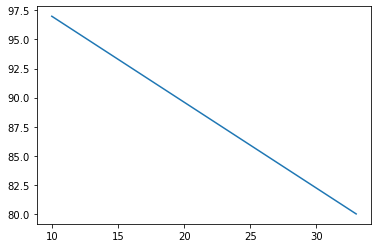

In [24]:
plotPatient(958, 'Platelets')

In [25]:
# import panel as pn

# pn.extension()

# pn.interact(plotPatient, patient=(1, len(clusteringPatients)), feature = list(clusteringPatients[0].interpolatedData.columns)).show()

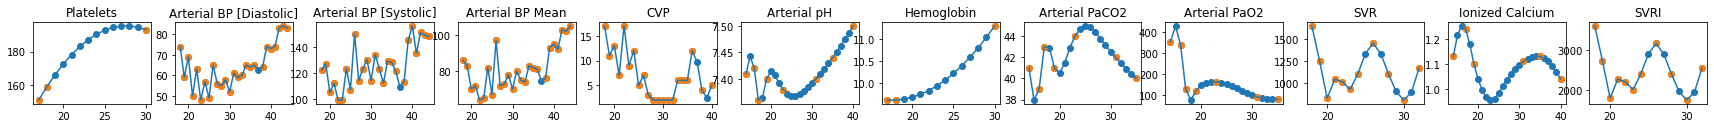

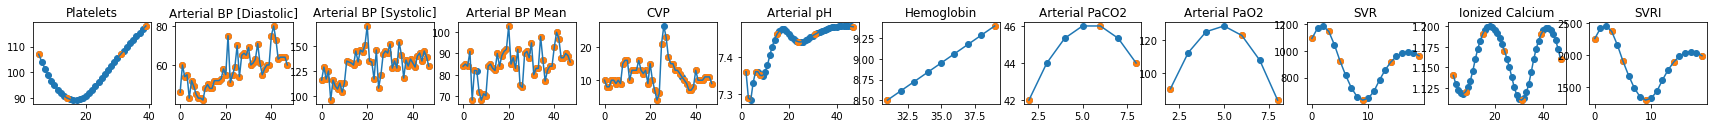

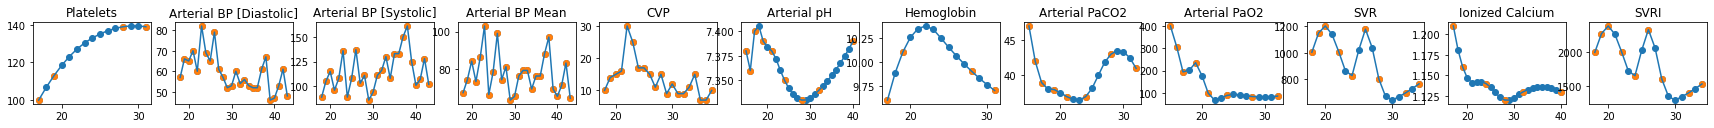

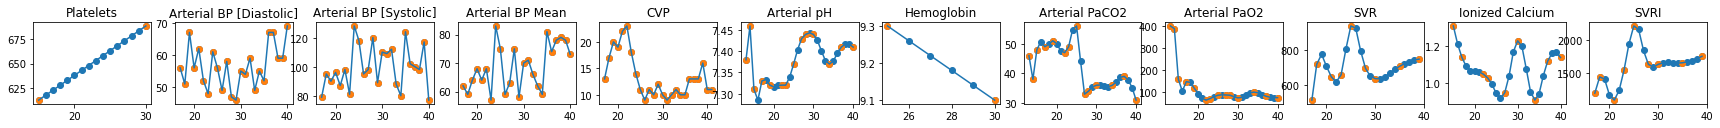

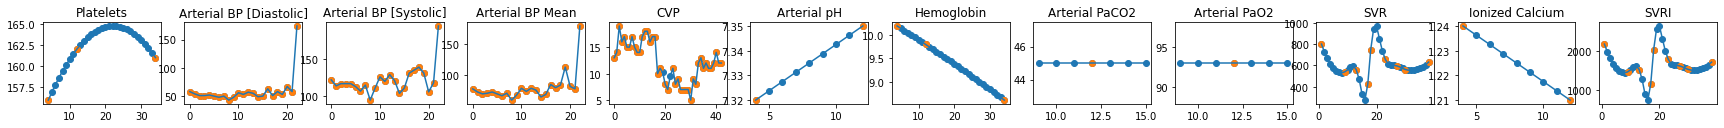

In [26]:

for i in range(len(clusteringPatients[:5])):

    # display(clusteringPatients[i].interpolatedData.head())

    fig = plt.figure(figsize = (30, 1.5))

    for idx, col in enumerate(clusteringPatients[i].interpolatedData.columns):
        plt.subplot(1, len(clusteringPatients[i].interpolatedData.columns), idx+1)

        plt.plot(clusteringPatients[i].interpolatedData.index, clusteringPatients[i].interpolatedData[col])
        plt.scatter(clusteringPatients[i].interpolatedData.index, clusteringPatients[i].interpolatedData[col])
        plt.scatter(clusteringPatients[i].clusteringColumns.index, clusteringPatients[i].clusteringColumns[col])
        plt.title(f"{col}")

    plt.show()



In [41]:

def formatForTimeSeries(column):

    stackedDF = pd.DataFrame([patient.interpolatedData[column].values for patient in clusteringPatients])

    # print(stackedDF.shape)

    stackedNumpy = stackedDF.to_numpy()

    cleanedNumpy = []

    for row in stackedNumpy:
        cleanedNumpy.append(row[~np.isnan(row)])


    dataFormatted = to_time_series_dataset([*cleanedNumpy])

    return dataFormatted



def timeSeriesCluster(column, clusters):

    # print(f"Clustering {column}")

    dataFormatted = formatForTimeSeries(column)


    # Change hyper-parameters for better results?

    # max iter 200 takes approx 4 minutes
    model = TimeSeriesKMeans(n_clusters=clusters, tol=1e-3, metric="dtw", max_iter=2, random_state=0, n_jobs=4)
    y_pred = model.fit_predict(dataFormatted)

    # Calculating the score takes ages
    # print(silhouette_score(dataFormatted, y_pred))

    

    return dataFormatted, y_pred, model



# Has it's own silhouette_score
# print(silhouette_score(data, y_pred))


In [49]:
def find_cached(df=None, hash=None):

    if hash is None:

        hash = hashlib.sha256(bytes(str(df), 'utf-8')).hexdigest()

    display(hash)


    try:
        cachedDF = pd.read_csv("./processingCache/" + hash + ".csv").set_index("Unnamed: 0")

        print("Using cached df")

        return cachedDF, hash

    except:

        return False, hash
    

In [58]:
clusteredDF, myHash = find_cached(clusteringPatients)

if clusteredDF is False:

    clusteredDF = pd.DataFrame()

    clusters = 5

    for column in tqdm(clusteringPatients[0].interpolatedData.columns):
        dataFormatted, y_pred, model = timeSeriesCluster(column, clusters)
        clusteredDF[column] = y_pred

    clusteredDF.to_csv("./processingCache/" + myHash + ".csv")
        


'8321f888b62847bcb3149e63466416d4ba96c932da1bbbfbede32a0883cd4a20'

Using cached df


In [59]:
scores = {}

# Using sampling for the silhouette score since calculating the score on the entire dataset takes ages
# Is this calculated right?
for column in clusteredDF.columns:
    y_pred = clusteredDF[column]
    test_size = 0.1
    sample_idx = np.random.choice(dataFormatted.shape[0], int(test_size * len(dataFormatted)), replace=False)
    test_sample_x = dataFormatted[sample_idx]
    test_sample_y = [y_pred[i] for i in sample_idx]
    while len(np.unique(test_sample_y)) < 2:
        print("Recalculating sample due to too few clusters")
        sample_idx = np.random.choice(dataFormatted.shape[0], int(test_size * len(dataFormatted)), replace=False)
        test_sample_x = dataFormatted[sample_idx]
        test_sample_y = [y_pred[i] for i in sample_idx]
    # print(test_sample_x, test_sample_y)
    score = silhouette_score(test_sample_x, test_sample_y)
    scores[column] = score

print(scores)

# display(clusteredDF)

Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
Recalculating sample due to too few clusters
{'Platelets': -0.21567723210391795, 'Arterial BP [Diastolic]': -0.07782743359190122, 'Arterial BP [Systolic]': -0.22636230623417963, 'Arterial BP Mean': -0.04459847137197528, 'CVP': -0.18544228936423726, 'Arterial pH': -0.30180420672840186, 'Hemoglobin': -0.09211544760293347, 'Arterial PaCO2': -0.16681798552103397, 'Arterial PaO2': -0.12889084543064636, 'SVR': 0.08237199615944653, 'Ionized Calcium': -0.2026459246291435, 'SVRI': 0.1594585445681011}


In [60]:
print(scores)


{'Platelets': -0.21567723210391795, 'Arterial BP [Diastolic]': -0.07782743359190122, 'Arterial BP [Systolic]': -0.22636230623417963, 'Arterial BP Mean': -0.04459847137197528, 'CVP': -0.18544228936423726, 'Arterial pH': -0.30180420672840186, 'Hemoglobin': -0.09211544760293347, 'Arterial PaCO2': -0.16681798552103397, 'Arterial PaO2': -0.12889084543064636, 'SVR': 0.08237199615944653, 'Ionized Calcium': -0.2026459246291435, 'SVRI': 0.1594585445681011}


In [61]:
np.seterr(all="ignore")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [62]:
def removeOutliers(data, threshold):
    stdDev = np.nanstd(data)
    # print(stdDev)
    mean = np.nanmean(data)
    # print(mean)
    normalised = [np.nanmean(np.abs(d - mean)) for d in data]
    mask = normalised < threshold * stdDev
    return data[mask], data[np.logical_not(mask)]

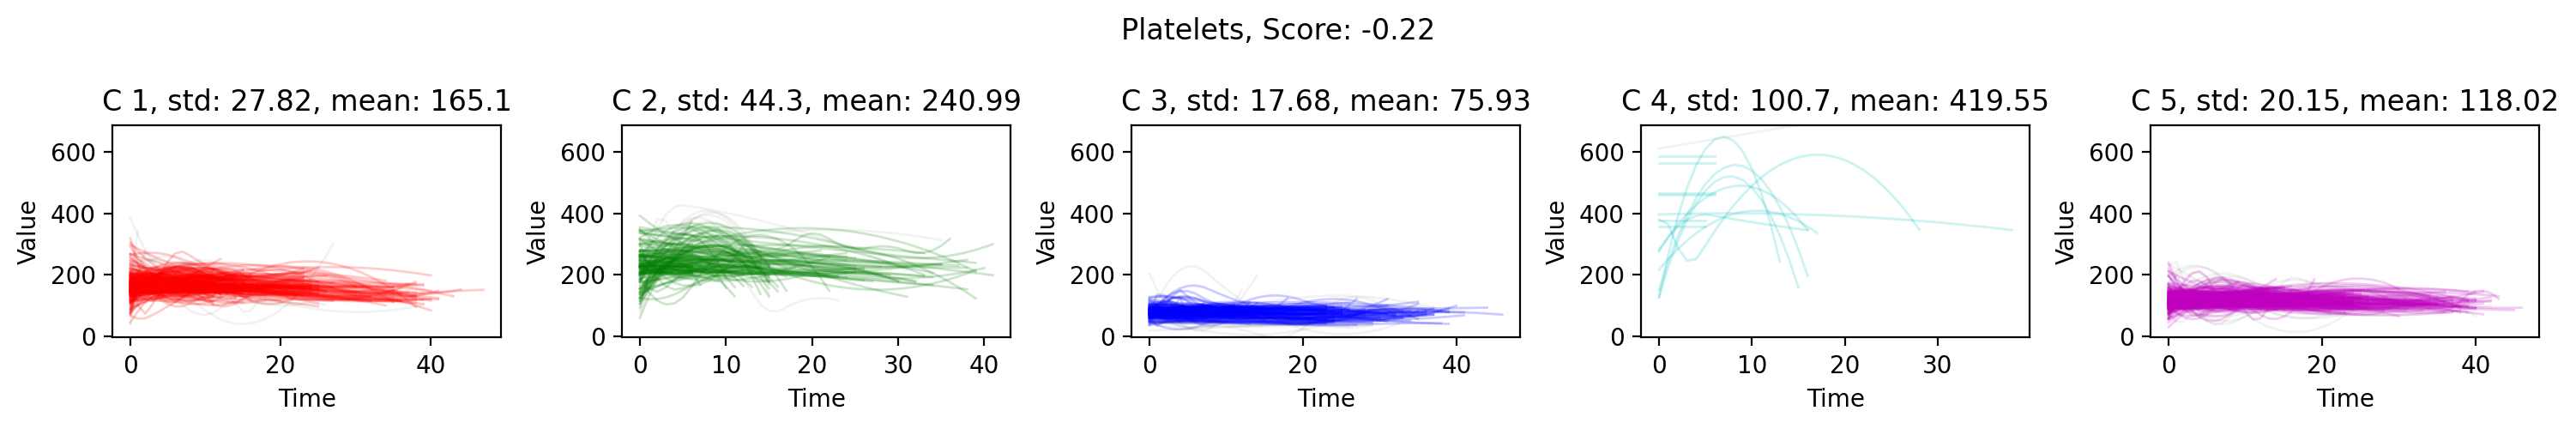

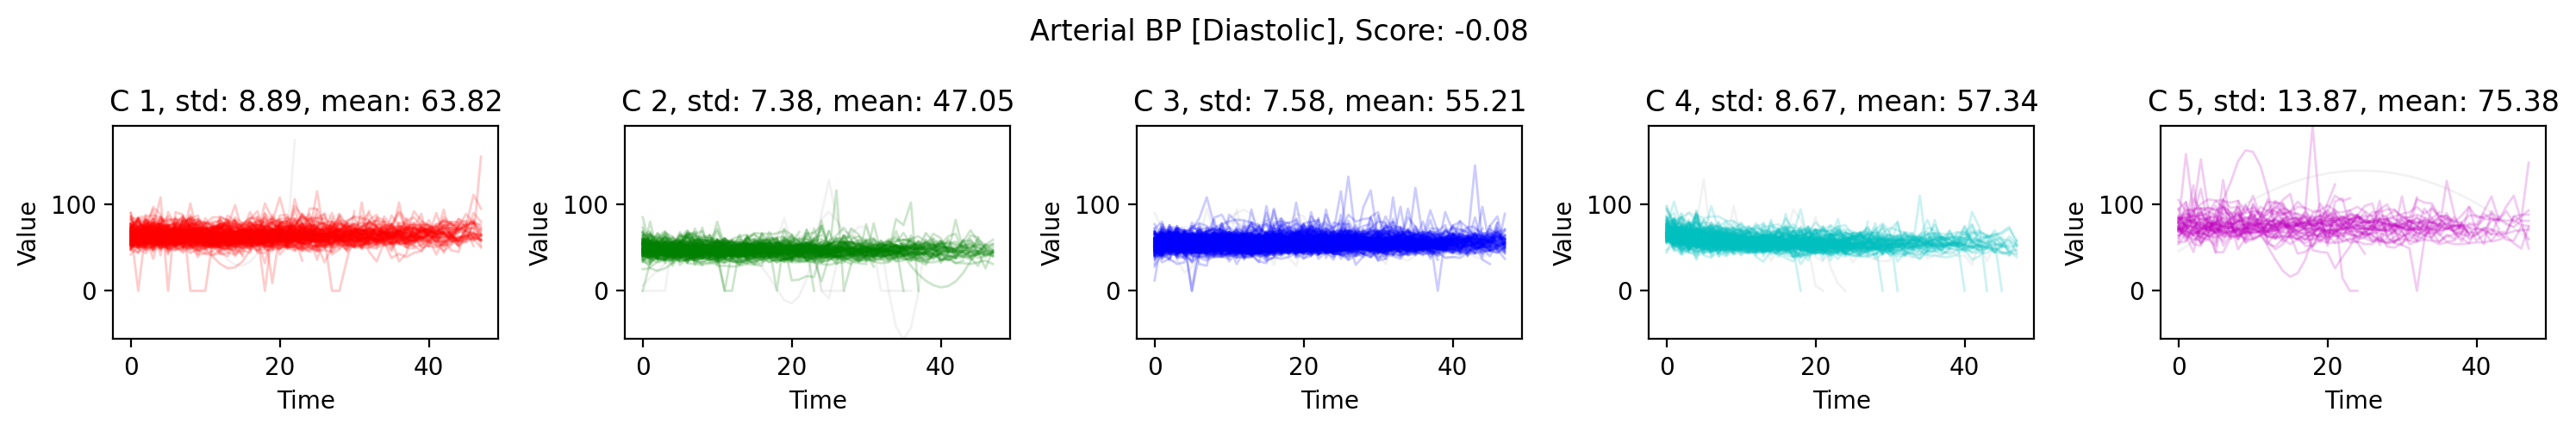

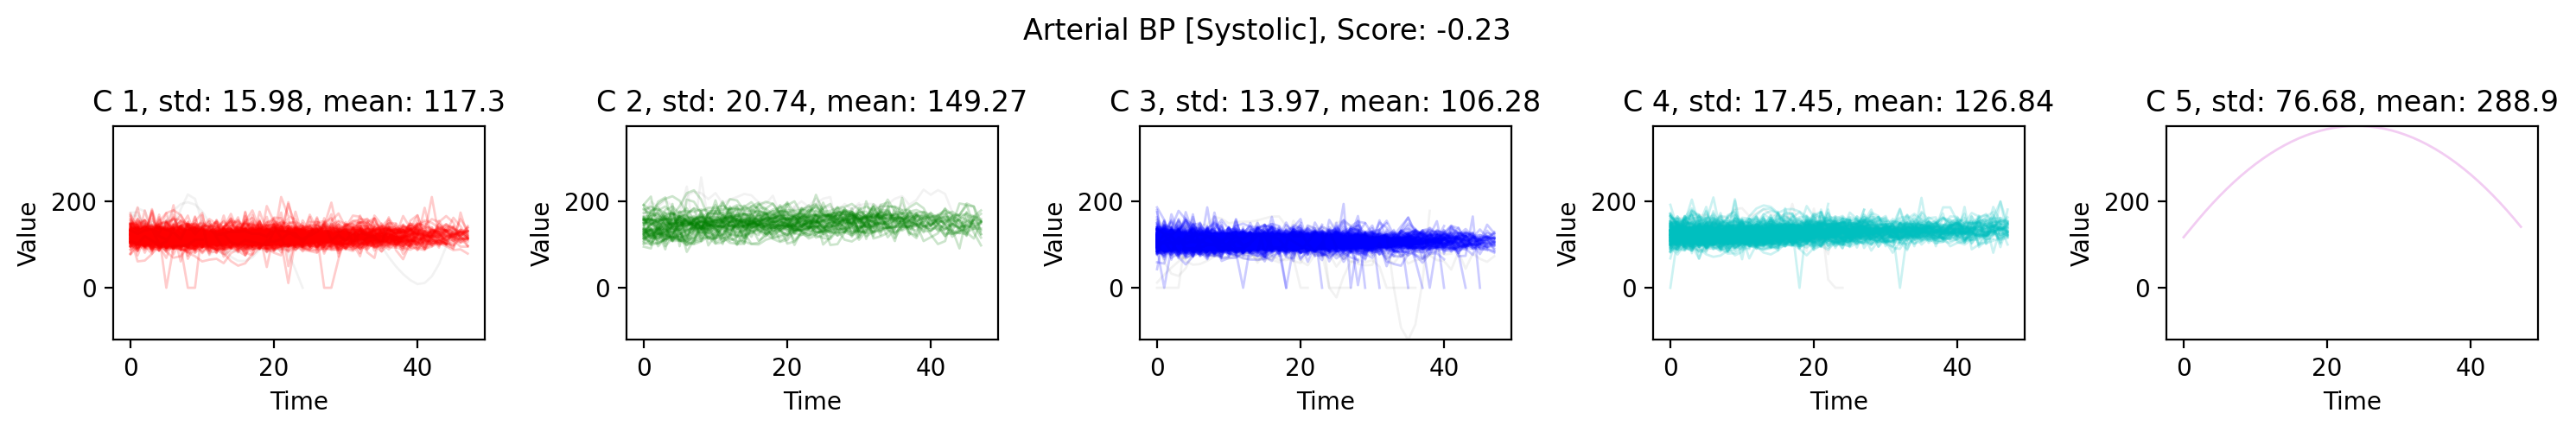

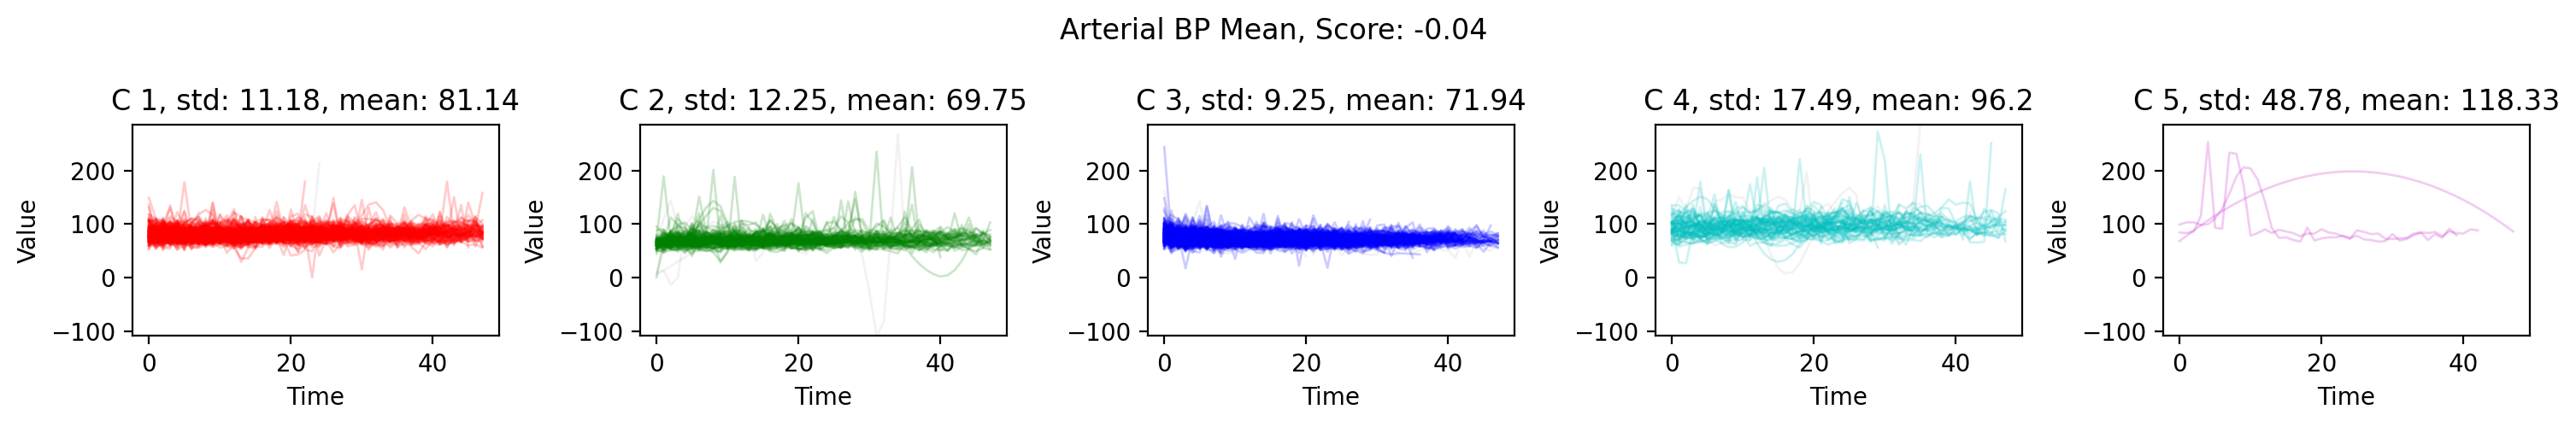

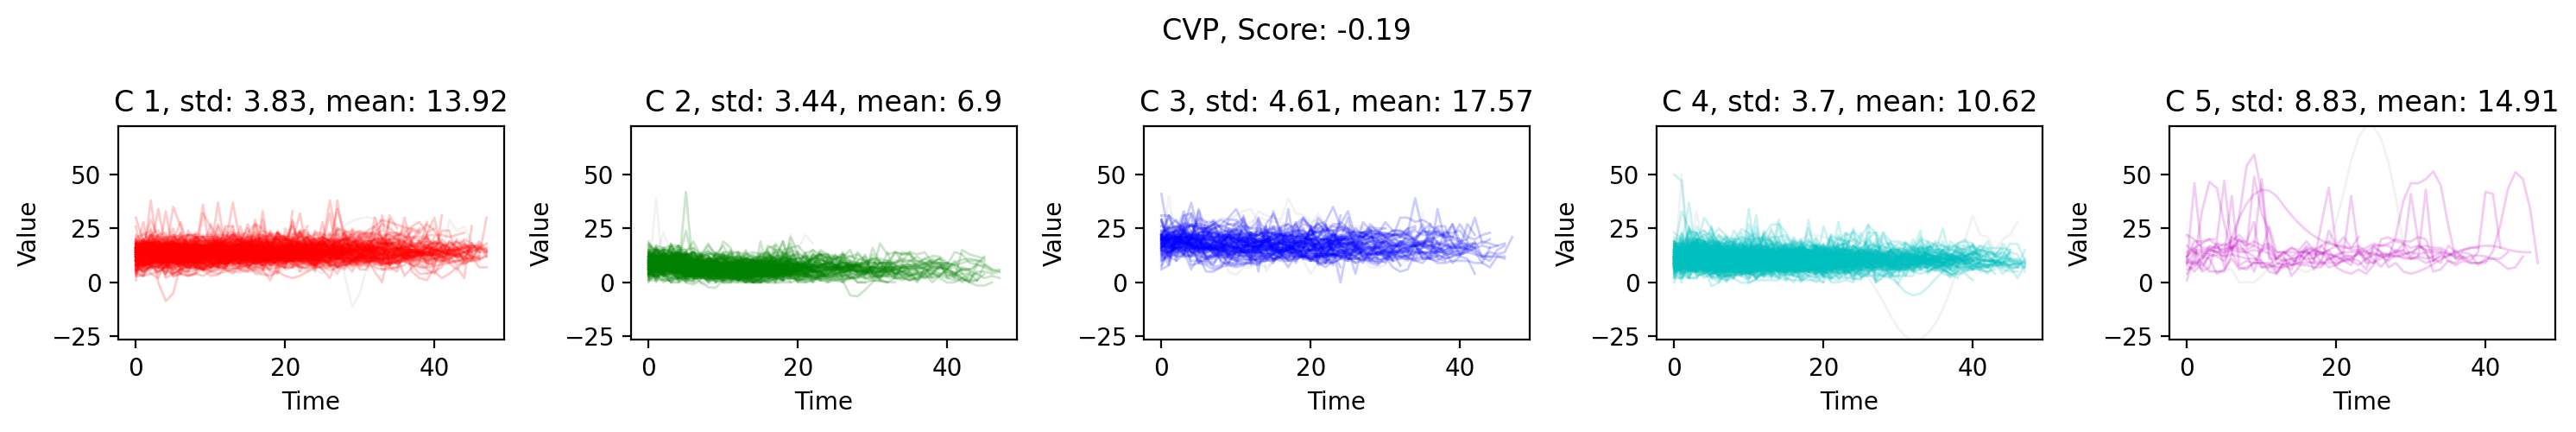

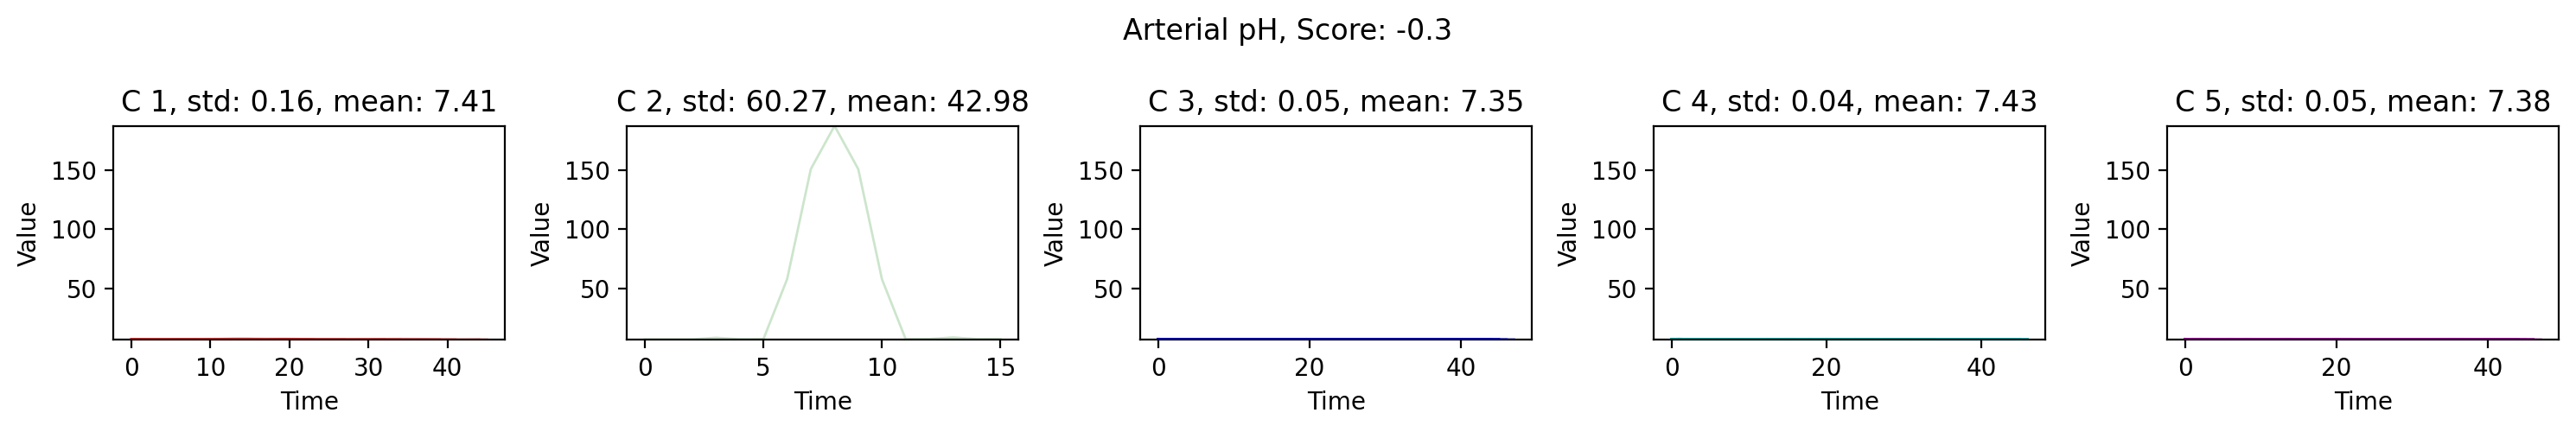

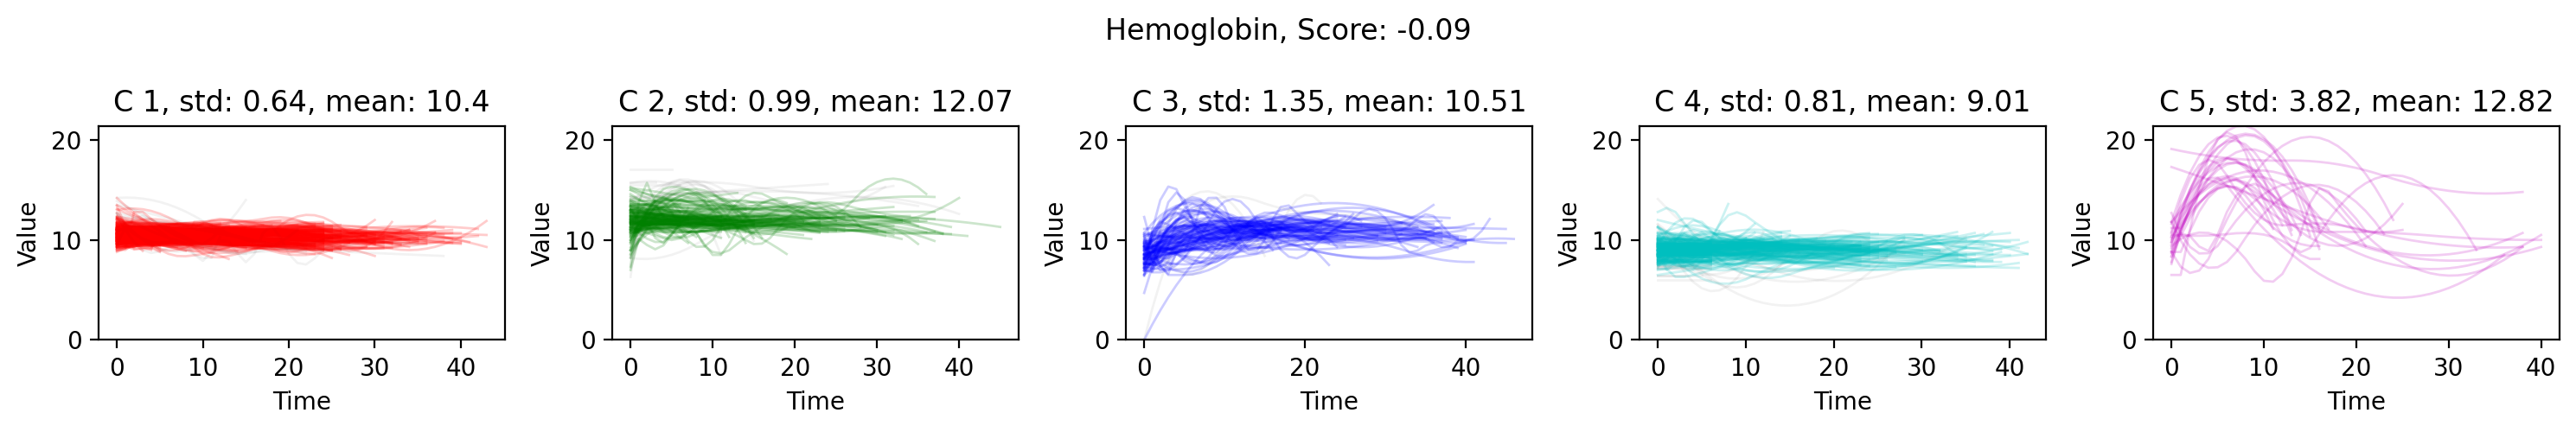

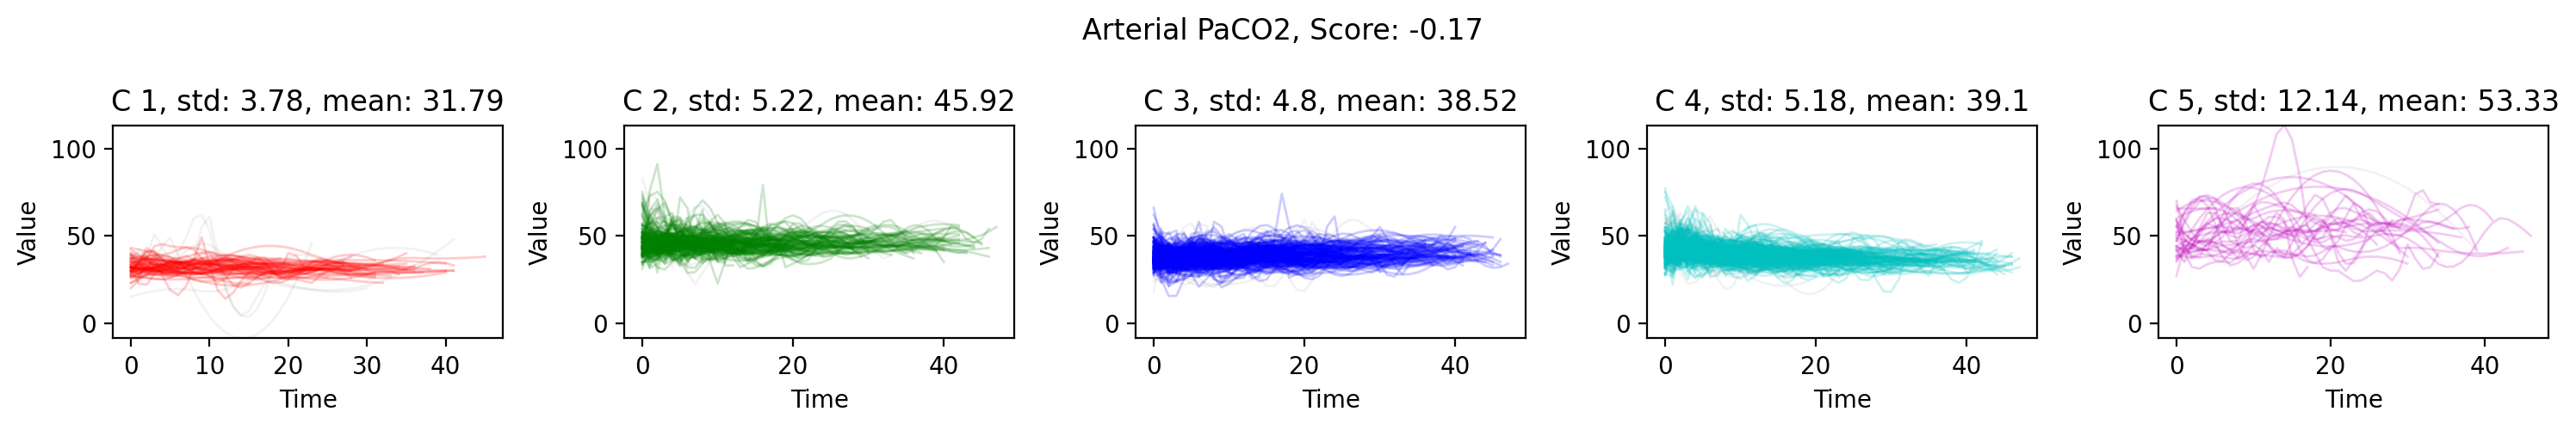

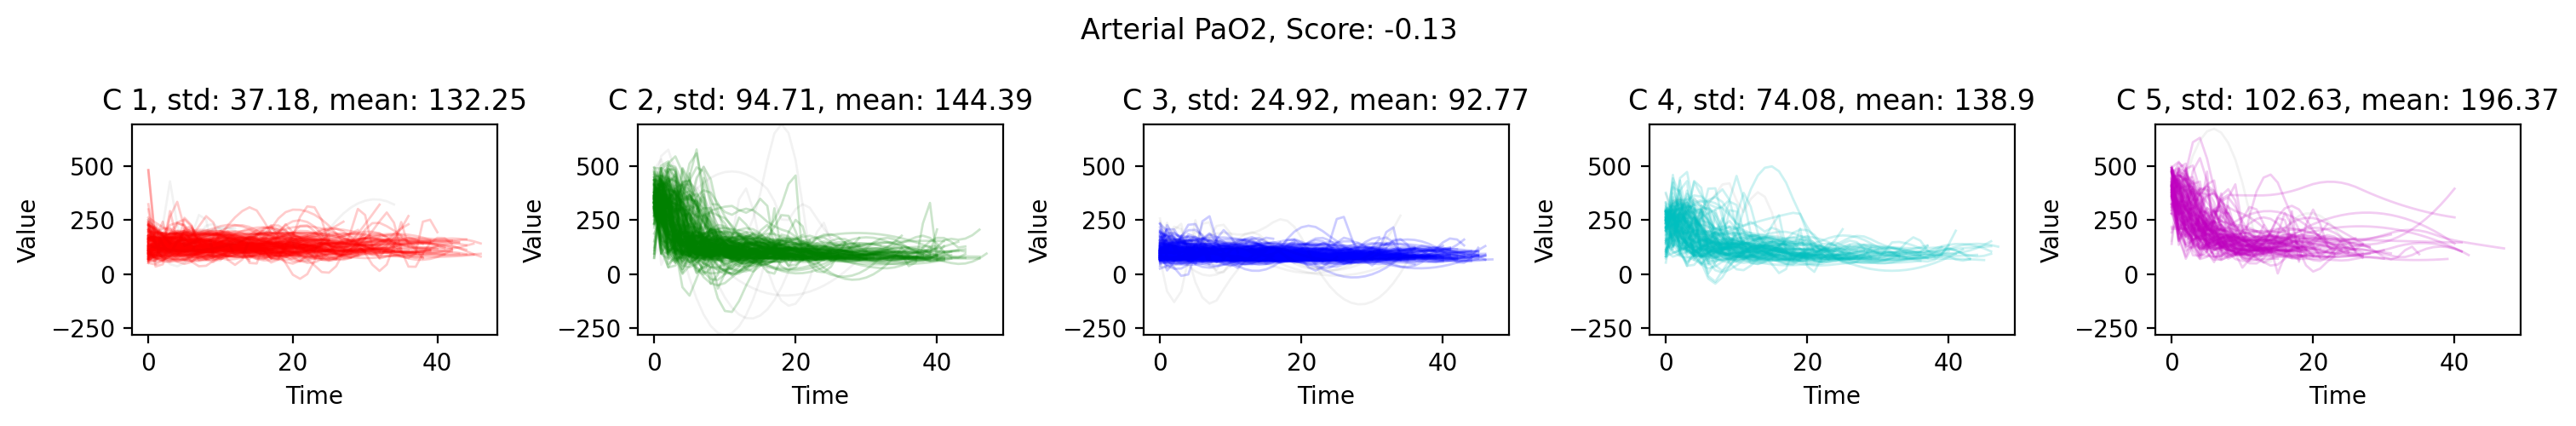

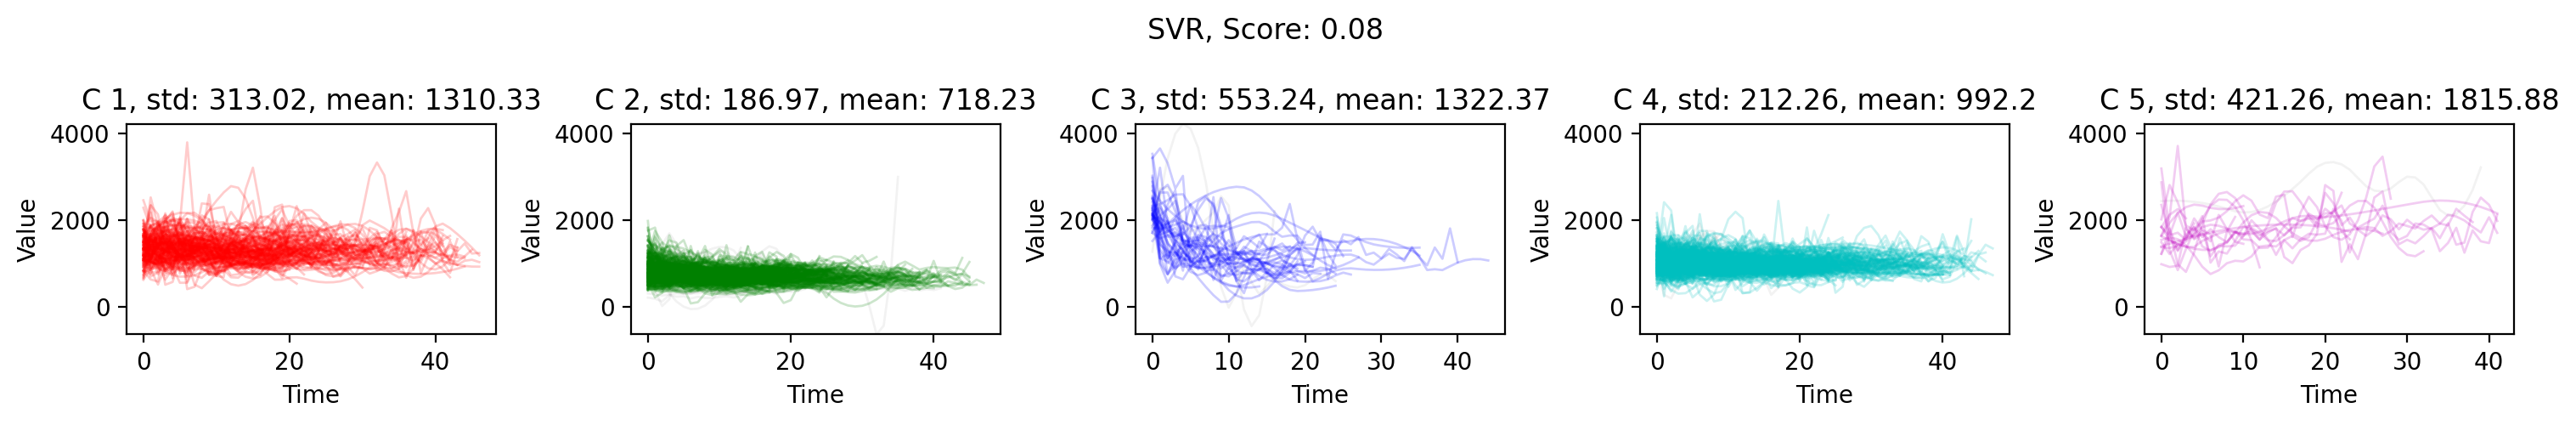

c:\Users\benma\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\benma\AppData\Local\Temp/ipykernel_28056/2683803288.py:4: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data)
C:\Users\benma\AppData\Local\Temp/ipykernel_28056/1002023841.py:40: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(withoutOutliers)


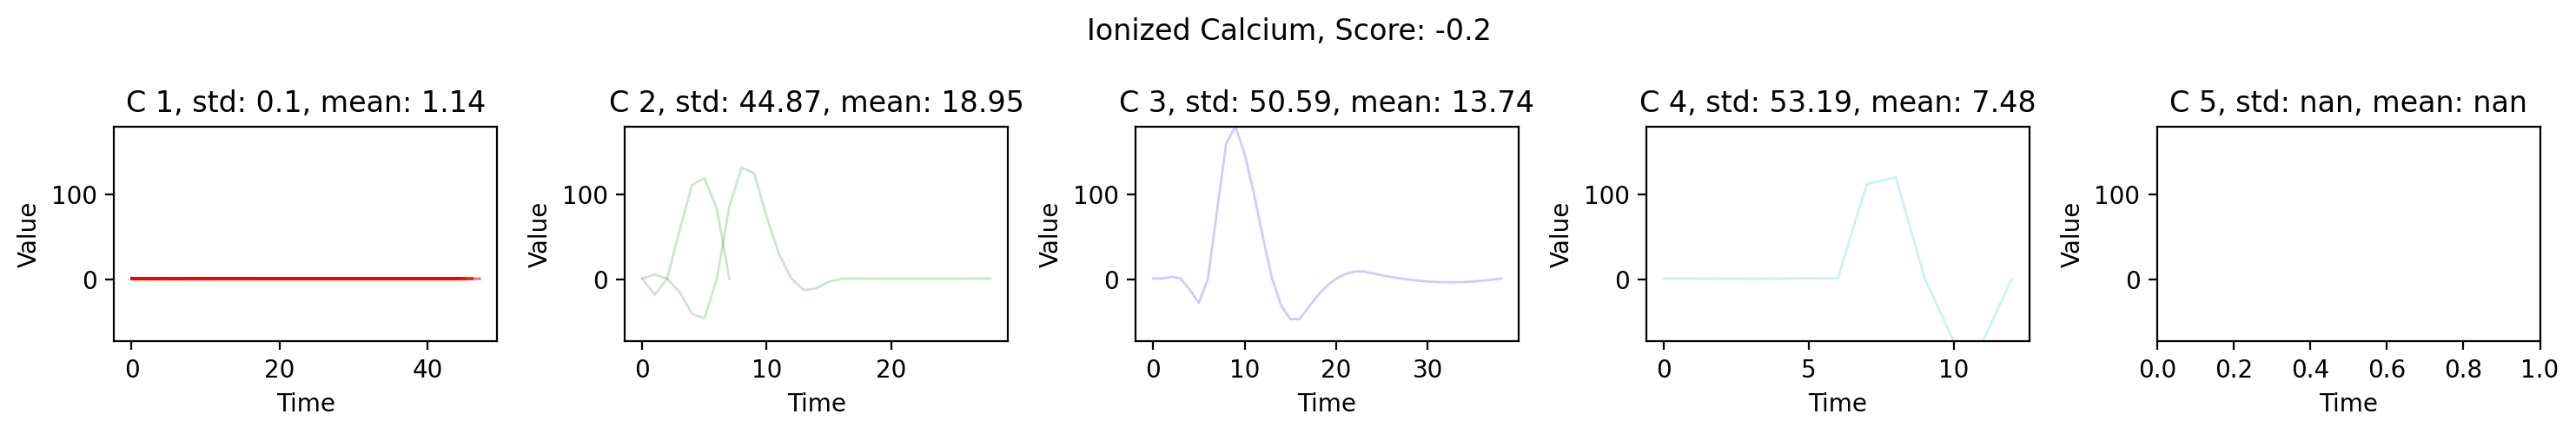

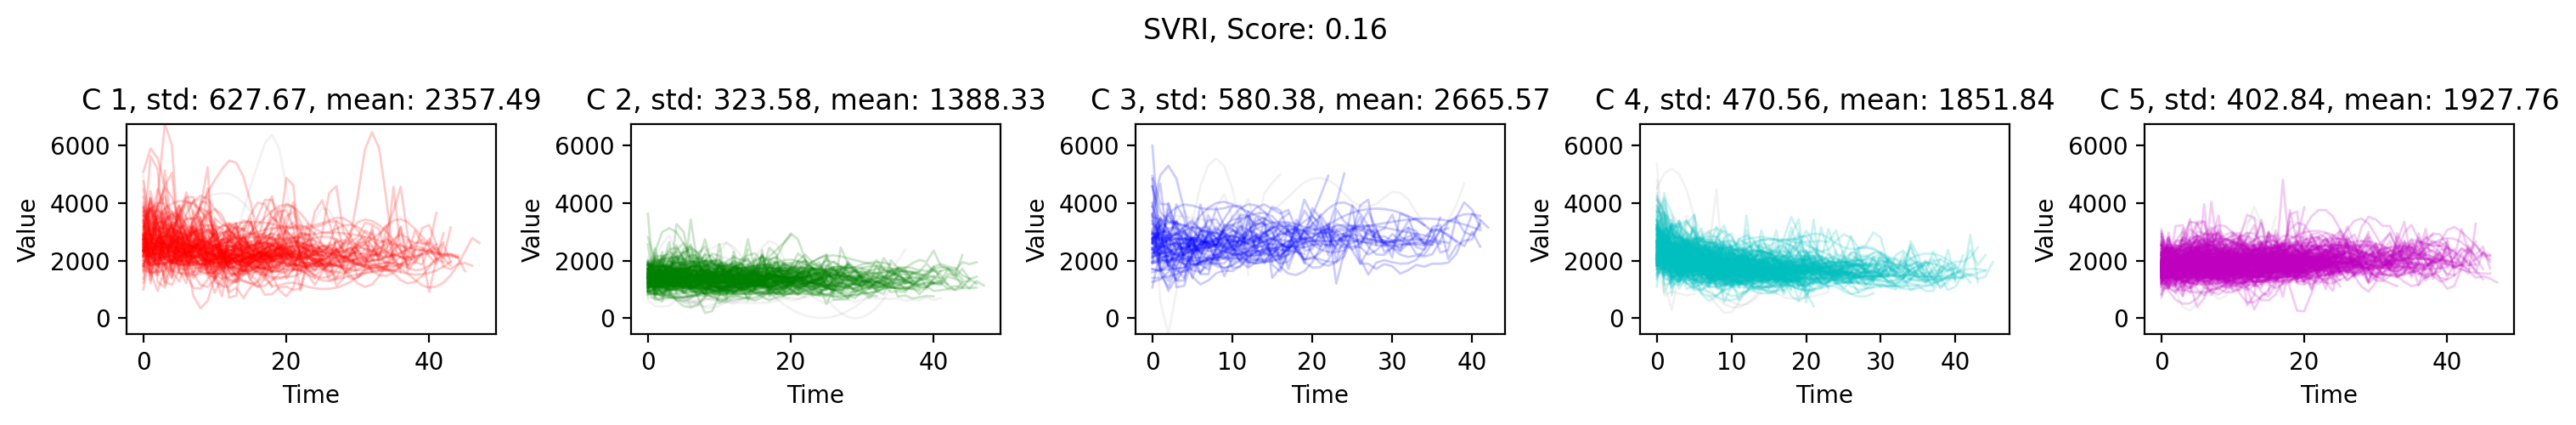

,Feature,StdDev,Mean
0,Platelets,27.823689,165.099611
1,Platelets,44.297756,240.985478
2,Platelets,17.678627,75.933925
3,Platelets,100.704217,419.548523
4,Platelets,20.149703,118.018842
5,Arterial BP [Diastolic],8.887692,63.817315
6,Arterial BP [Diastolic],7.382283,47.049519
7,Arterial BP [Diastolic],7.580362,55.206455
8,Arterial BP [Diastolic],8.665807,57.336757
9,Arterial BP [Diastolic],13.867124,75.380639


In [66]:
colours = {0:'r', 1:'g', 2:'b', 3:'c', 4:'m', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'purple', 10:'pink'}

clusterMetricsList = []

for col in clusteredDF.columns:


    fig = plt.figure(figsize=(clusters*3,2.5), dpi=200)

    fig.suptitle(f"{col}, Score: {np.round(scores[col], 2)}")

    colData = [np.pad(j.interpolatedData[col].values, (0, 48 - len(j.interpolatedData[col].values)), 'constant', constant_values = (np.NaN, np.NaN)) for j in clusteringPatients]
    # print(colData)

    minVal, maxVal = np.nanmin([np.nanmin(j) for j in colData]), np.nanmax([np.nanmax(j) for j in colData])

    for i in range(clusters):
        plt.subplot(1, clusters, i+1)

        y_pred = clusteredDF[col]

        # dataCluster = np.array(colData)[y_pred == i]

        dataCluster = formatForTimeSeries(col)[y_pred == i]

        withoutOutliers, outliers = removeOutliers(dataCluster, 1.5)
        
        # print(f"Num removed: {len(dataCluster) - len(withoutOutliers)}")

        # print(len(dataCluster))
        # print(len(withoutOutliers))
        
        for sample in outliers:
            plt.plot(sample, c='black', alpha=0.05, linewidth=1)
        
        for sample in withoutOutliers:
            plt.plot(sample, c=colours[i], alpha=0.2, linewidth=1)

        stdDev = np.nanstd(withoutOutliers)
        mean = np.nanmean(withoutOutliers)

        clusterMetricsList.append([col, stdDev, mean])

        plt.title(f"C {i+1}, std: {np.round(stdDev, 2)}, mean: {np.round(mean, 2)}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        # print(dataCluster)
        # print(np.nanstd(dataCluster))
        plt.ylim(minVal, maxVal)

        
    plt.tight_layout()
    plt.show()


clusterMetricsDF = pd.DataFrame(data = clusterMetricsList, columns=['Feature', 'StdDev', 'Mean'])
display(clusterMetricsDF)


In [67]:
# from sklearn.preprocessing import KBinsDiscretizer  
# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

display(clusteredDF.head())

orderedDF = copy.copy(clusteredDF)

for name, subset in clusterMetricsDF.groupby('Feature'):

    # clusterData = [np.pad(j.interpolatedData[col].values, (0, 48 - len(j.interpolatedData[col].values)), 'constant', constant_values = (np.NaN, np.NaN)) for j in clusteringPatients]

    orderedStdDev = subset.reset_index().sort_values(by='StdDev')

    before = orderedStdDev.index
    after = orderedStdDev.reset_index().index

    mapping = {before[i]: after[i] for i in range(len(before))}

    # print(mapping)

    orderedDF[name] = orderedDF[name].map(mapping)

display(orderedDF.head())


,Platelets,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial BP Mean,CVP,Arterial pH,Hemoglobin,Arterial PaCO2,Arterial PaO2,SVR,Ionized Calcium,SVRI
Unnamed: 0,,,,,,,,,,,,
0,0,0,3,0,1,3,0,3,1,3,0,2
1,4,2,3,0,3,3,3,1,2,3,0,4
2,4,3,0,2,3,2,0,2,1,1,0,3
3,3,2,2,1,3,4,3,3,1,1,0,1
4,0,0,3,0,3,2,3,1,2,1,0,4


,Platelets,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial BP Mean,CVP,Arterial pH,Hemoglobin,Arterial PaCO2,Arterial PaO2,SVR,Ionized Calcium,SVRI
Unnamed: 0,,,,,,,,,,,,
0,2,3,2,1,0,0,0,2,3,1,0,3
1,1,1,2,1,1,0,1,3,0,1,0,1
2,1,2,1,0,1,2,0,1,3,0,0,2
3,4,1,0,2,1,1,1,2,3,0,0,0
4,2,3,2,1,1,2,1,3,0,0,0,1


In [65]:
cat = Categorizer()

mapped = cat.map_types(data = {"ordered":orderedDF}, mapping={0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'})

print(mapped)

{'ordered':             Platelets_high  Platelets_low  Platelets_medium  \
Unnamed: 0                                                    
0                        0              0                 1   
1                        0              1                 0   
2                        0              1                 0   
3                        0              0                 0   
4                        0              0                 1   
...                    ...            ...               ...   
954                      0              0                 1   
955                      0              1                 0   
956                      0              0                 1   
957                      0              1                 0   
958                      0              0                 0   

            Platelets_very_high  Platelets_very_low  \
Unnamed: 0                                            
0                             0                   0   
1  

In [ ]:
# TODO Move tensor operations into the LEN_Scorer class then score on this dataset.
